# Deutsch-Jozsa Algorithm

In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

In [2]:
qml.drawer.use_style(style='sketch')

**Balanced or constant? (for multivariable binary function)**

Consider a multivariate binary function $f$ defined as follows:

$$
f: \{0,1\}^n \rightarrow \{0,1\}
$$

There are $2^n$ possible inputs and so that $2^{2^n}$ possible functions.

We want to determine whether the function is constant or balanced (1/2 of the outputs are 0 and 1/2 are 1).
How many times do we need to evaluate the function to determine this?

## Classical Solution

In [3]:
def is_constant(f, n:int):
    inputs = [bin(i)[2:].zfill(n) for i in range(2**n)]
    inputs = list(map(lambda x: [int(i) for i in x], inputs))
    return all([f(x) == f(inputs[0]) for x in inputs])

In [4]:
# Worst case scenario
def f(x):
    return 0

In [5]:
import timeit

def query_complexity(n):
    times = []
    for i in range(1, n+1):
        start = timeit.default_timer()
        is_constant(f, i)
        stop = timeit.default_timer()
        times.append(stop - start)
    return times

In [6]:
classical_times = query_complexity(10)

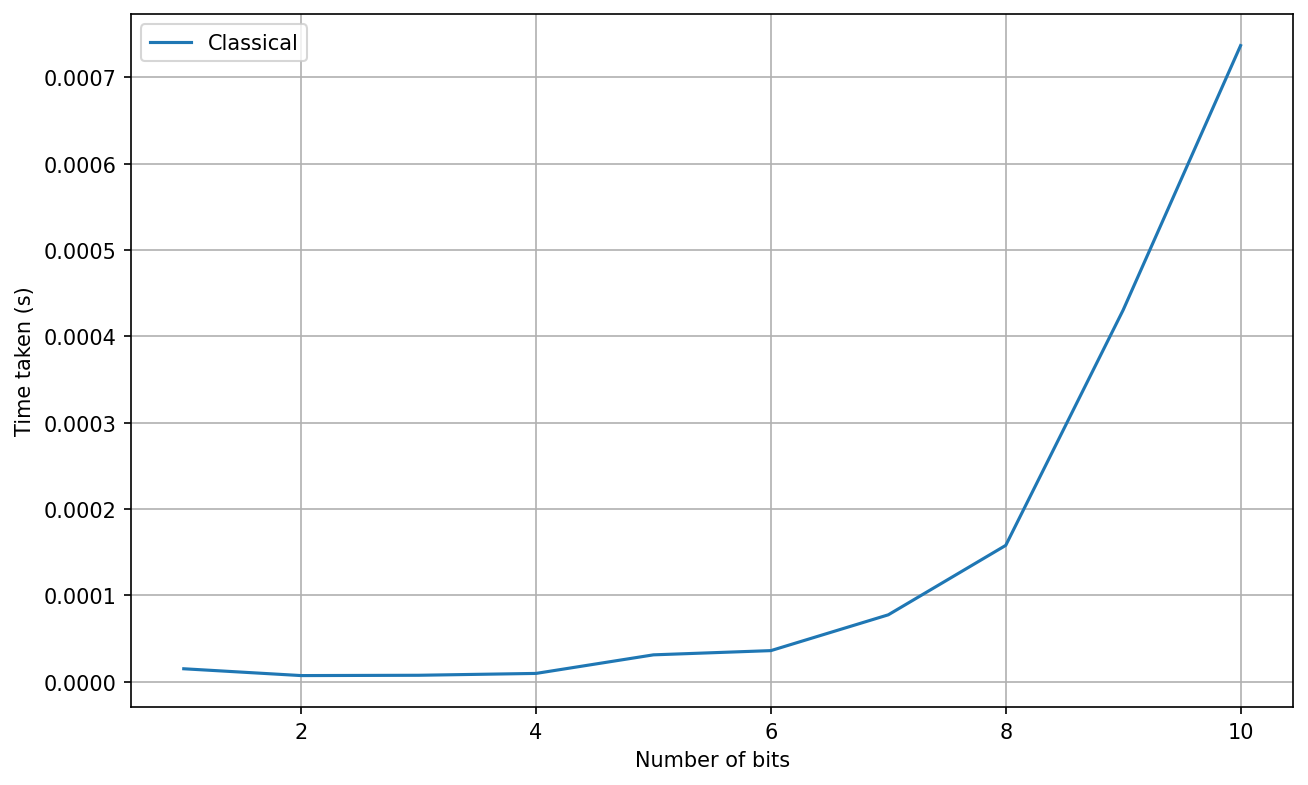

In [7]:
plt.figure(figsize=(10, 6), dpi=150)
plt.plot(range(1, 11), classical_times, label='Classical')
plt.xlabel('Number of bits')
plt.ylabel('Time taken (s)')
plt.legend()
plt.grid()
plt.show()

## Quantum Solution

Consider the unitary operator $U_f$ defined as follows:

$$
U_f(|x_0\rangle \otimes \cdots \otimes |x_{n-1}\rangle \otimes |y\rangle) = |x_0\rangle \otimes \cdots \otimes |x_{n-1}\rangle \otimes |y \oplus f(x_0, \cdots, x_{n-1})\rangle
$$

For example, suppose $n=2$. With $z$-basis, the unitary operator $U_f$ is represented as follows:

- `000 -> 000 if f(00) = 0 else 001`
- `001 -> 001 if f(00) = 0 else 000`
- `010 -> 010 if f(01) = 0 else 011`
- ...

In [8]:
[x for x in reversed([0,1])]

[1, 0]

In [9]:
from pennylane.operation import Operation

class Oracle(Operation):
    num_params = 2
    num_wires = qml.operation.AnyWires

    @staticmethod
    def compute_decomposition(case, n, wires):
        gates = []
        if case == 'balanced':
            b = np.random.randint(1, 2**n)
            b_str = f'{b:0{n}b}'
            
            for i in range(len(b_str)):
                if b_str[i] == '1':
                    gates.append(qml.PauliX(wires=wires[i]))
            
            for i in range(len(b_str)):
                gates.append(qml.CNOT(wires=[wires[i], wires[-1]]))
            
            for i in range(len(b_str)):
                if b_str[i] == '1':
                    gates.append(qml.PauliX(wires=wires[i]))
        
        elif case == 'constant':
            if np.random.randint(2) == 1:
                gates.append(qml.PauliX(wires=wires[-1]))
                
        return gates

**Explanation of `Oracle`**

1) Balance case
    1) Generate instruction to determine the function (binary string)
        1) Generate random integer between 1 and $2^n - 1$
        2) Convert the integer to binary (e.g. `3 -> 011`)
    2) Read instruction and construct the oracle
        1) If $i$-th bit of the instruction is 1, apply $X$ gate to the $i$-th qubit for all $i$ from 0 to $n-1$
            $$
            |x_0\rangle \otimes \cdots \otimes |x_i\rangle \otimes \cdots \otimes |x_{n-1}\rangle \otimes |y\rangle \rightarrow |x_0\rangle \otimes \cdots \otimes |x_i \oplus 1\rangle \otimes \cdots \otimes |x_{n-1}\rangle \otimes |y\rangle
            $$
        2) Apply $\text{CNOT}$ gates to first $n$ qubits with the last qubit as the target
            $$
            |x'_0\rangle \otimes \cdots \otimes |x'_{n-1}\rangle \otimes |y\rangle \rightarrow |x'_0\rangle \otimes \cdots \otimes |x'_{n-1}\rangle \otimes |y \oplus x'_0 \oplus \cdots \oplus x'_{n-1}\rangle
            $$
        3) If i-th bit of the instruction is 1, apply X gate to the i-th qubit for all i from 0 to n-1
            $$
            |x'_0\rangle \otimes \cdots \otimes |x'_{n-1}\rangle \otimes |y \oplus x'_0 \oplus \cdots \oplus x'_{n-1}\rangle \rightarrow |x_0\rangle \otimes \cdots \otimes |x_{n-1}\rangle \otimes |y \oplus x'_0 \oplus \cdots \oplus x'_{n-1}\rangle
            $$
2) Constant case
    - Apply X gate to the last qubit with probability 1/2
    $$
    |x_0\rangle \otimes \cdots \otimes |x_{n-1}\rangle \otimes |y\rangle \rightarrow |x_0\rangle \otimes \cdots \otimes |x_{n-1}\rangle \otimes ( |y\rangle \text{ or } |y \oplus 1\rangle )
    $$

For example, suppose instruction is `01` for balanced case. The oracle is represented as follows:

1) Apply $X$ gate to the second qubit
    $$
    |x_0\rangle \otimes |x_1\rangle \otimes |y\rangle \rightarrow |x_0\rangle \otimes |x_1 \oplus 1\rangle \otimes |y\rangle
    $$

2) Apply $\text{CNOT}$ gates to first two qubits with the last qubit as the target
    $$
    |x_0\rangle \otimes |x_1 \oplus 1\rangle \otimes |y\rangle \rightarrow |x_0\rangle \otimes |x_1 \oplus 1\rangle \otimes |y \oplus x_0 \oplus x_1 \oplus 1\rangle
    $$

3) Apply $X$ gate to the second qubit
    $$
    |x_0\rangle \otimes |x_1 \oplus 1\rangle \otimes |y \oplus x_0 \oplus x_1 \oplus 1\rangle \rightarrow |x_0\rangle \otimes |x_1\rangle \otimes |y \oplus x_0 \oplus x_1 \oplus 1\rangle
    $$
    We can find below:
    $$
    f(x_0, x_1) = x_0 \oplus x_1 = \text{XOR}(x_0, x_1)
    $$

In [10]:
dev = qml.device('default.qubit', wires=3)

@qml.qnode(dev)
def oracle_test(state):
    qml.BasisStatePreparation(state, wires=range(2))
    Oracle('balanced', 2, wires=range(3))
    return qml.probs(wires=range(3))

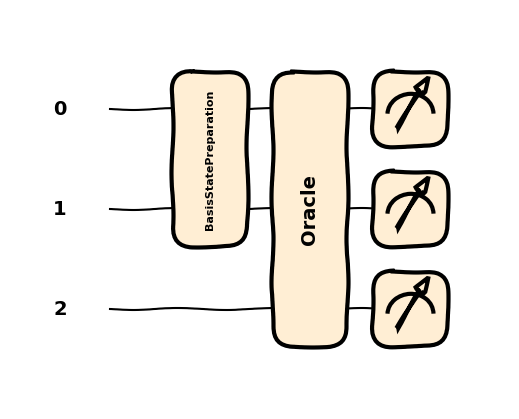

In [11]:
qml.draw_mpl(oracle_test)([0, 1])
plt.show()

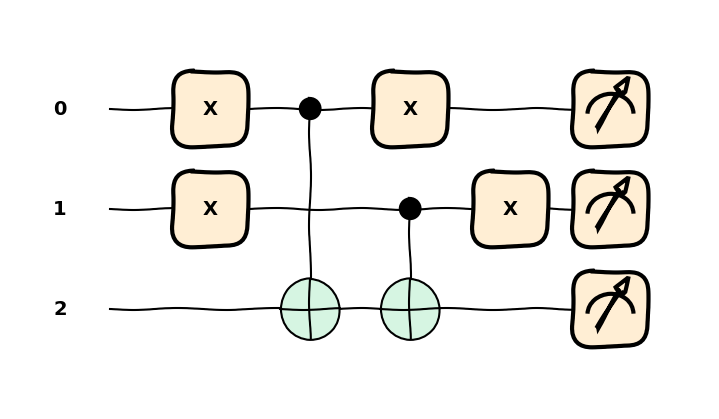

In [12]:
qml.draw_mpl(oracle_test, expansion_strategy='device')([0, 0])
plt.show()

In [13]:
for state in [[0,0], [0,1], [1,0], [1,1]]:
    result = oracle_test(state)
    # Computational basis to z-basis
    index = result.tolist().index(1)
    z_basis = bin(index)[2:].zfill(3)
    print(f'Oracle output for state {state[0]}{state[1]} is {z_basis}')

Oracle output for state 00 is 001
Oracle output for state 01 is 010
Oracle output for state 10 is 100
Oracle output for state 11 is 111


In [14]:
def gen_deutsch_jozsa(case:str,n:int):
    dev = qml.device('default.qubit', wires=n+1)
    @qml.qnode(dev)
    def circuit():
        # Apply X gate to the last qubit to make the state |1>
        qml.PauliX(wires=n)

        # Add barrier to separate input state from rest of circuit
        qml.Barrier(wires=range(n+1))

        # Apply Hadamard gates to all qubits
        for i in range(n+1):
            qml.Hadamard(wires=i)

        # Apply U_f
        Oracle(case, n, wires=range(n+1))

        # Apply Hadamard gates to all qubits
        for i in range(n):
            qml.Hadamard(wires=i)
        
        # Measure all qubits
        return qml.probs(wires=range(n))
    return dev, circuit

In [15]:
dev, circuit = gen_deutsch_jozsa('balanced', 2)

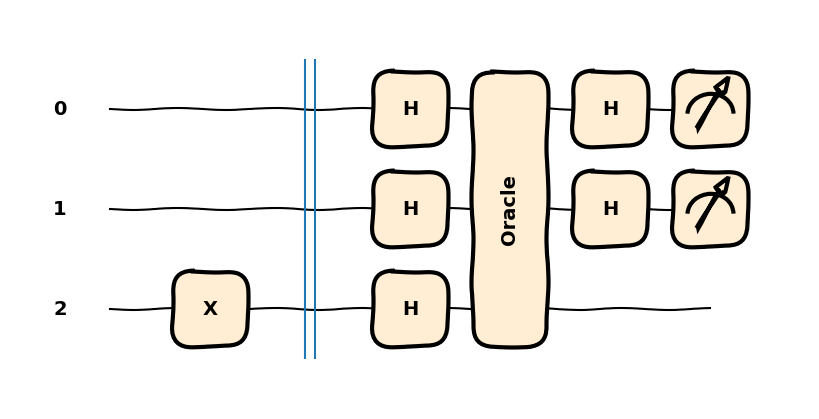

In [16]:
qml.draw_mpl(circuit)()
plt.show()

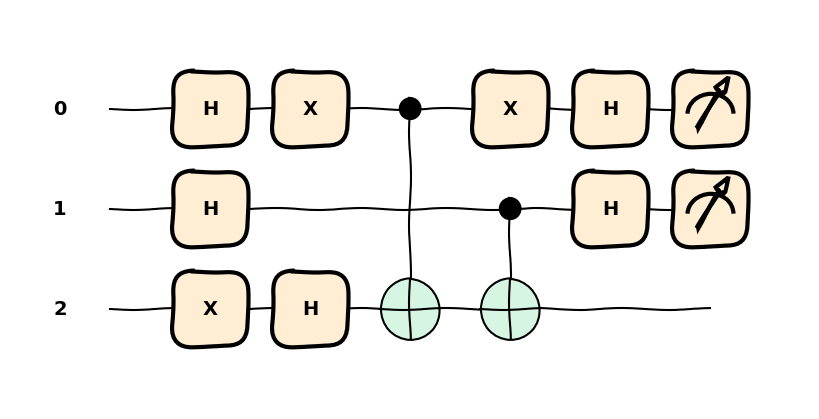

In [17]:
qml.draw_mpl(circuit, expansion_strategy='device')()
plt.show()

**Walsh-Hadamard transformation**

To understand above circuit, we need to understand the Walsh-Hadamard transformation.

Consider the following unitary operator $W$ defined as follows:
$$
W = H^{\otimes n} = H \otimes \cdots \otimes H
$$
where $H$ is the Hadamard gate.

Let apply $W$ to the $n$-qubit state $|x\rangle$:
$$
\begin{aligned}
W|x\rangle &= H^{\otimes n}|x\rangle = H|x_0\rangle \otimes \cdots \otimes H|x_{n-1}\rangle \\
&= \frac{1}{\sqrt{2}}(|0\rangle + (-1)^{x_0}|1\rangle) \otimes \cdots \otimes \frac{1}{\sqrt{2}}(|0\rangle + (-1)^{x_{n-1}}|1\rangle) \\
&= \frac{1}{\sqrt{2^n}}\sum_{y=0}^{2^n-1}(-1)^{x_0y_0 + \cdots + x_{n-1}y_{n-1}}|y\rangle \\
&= \frac{1}{\sqrt{2^n}}\sum_{y=0}^{2^n-1}(-1)^{x \cdot y}|y\rangle
\end{aligned}
$$

**Explanation of the circuit**

1) Apply X gate to the last qubit (the ancilla qubit) to make it |1>

2) Apply Hadamard gates to all qubits
    $$
    |0\rangle^{\otimes n} \otimes |1\rangle \xrightarrow{H^{\otimes n+1}} \frac{1}{\sqrt{2^n}} \sum_{x=0}^{2^n-1} |x\rangle \otimes \frac{1}{\sqrt{2}}(|0\rangle - |1\rangle)
    $$
    Here, $|x\rangle$ denotes $x$-th computational basis state.

3) Apply $U_f$
    $$
    \begin{aligned}
    \frac{1}{\sqrt{2^n}} \sum_{x=0}^{2^n-1} |x\rangle \otimes \frac{1}{\sqrt{2}}(|0\rangle - |1\rangle) &\xrightarrow{U_f} \frac{1}{\sqrt{2^n}} \sum_{x=0}^{2^n-1} |x\rangle \otimes \frac{1}{\sqrt{2}}(|f(x)\rangle - |1 \oplus f(x)\rangle) \\
    &= \frac{1}{\sqrt{2^n}} \sum_{x=0}^{2^n-1} (-1)^{f(x)} |x\rangle \otimes \frac{1}{\sqrt{2}}(|0\rangle - |1\rangle)
    \end{aligned}
    $$
    Thus, first $n$ qubits and the ancilla qubit are decoupled.

4) Apply Hadamard gates to first $n$ qubits
    $$
    \begin{aligned}
    \frac{1}{\sqrt{2^n}} \sum_{x=0}^{2^n-1} (-1)^{f(x)} |x\rangle \xrightarrow{H^{\otimes n}} &\frac{1}{2^n} \sum_{x=0}^{2^n-1} \sum_{y=0}^{2^n-1} (-1)^{f(x)} (-1)^{x \cdot y} |y\rangle \\
    &= \frac{1}{2^n} \sum_{y=0}^{2^n-1} \left( \sum_{x=0}^{2^n-1} (-1)^{f(x) + x \cdot y} \right) |y\rangle
    \end{aligned}
    $$

5) Measure first $n$ qubits to obtain $P(|y\rangle = |0\rangle^{\otimes n})$
    $$
    P(|y\rangle = |0\rangle^{\otimes n}) = \left| \frac{1}{2^n} \sum_{x=0}^{2^n-1} (-1)^{f(x)} \right|^2
    $$
    - If $f$ is constant, then $P(|y\rangle = |0\rangle^{\otimes n}) = 1$.

    - If $f$ is balanced, then $P(|y\rangle = |0\rangle^{\otimes n}) = 0$.

    - If $f$ is neither constant nor balanced, then $P(|y\rangle = |0\rangle^{\otimes n}) \in (0,1)$.
        

In [18]:
def is_equal(a:float, b:float, rtol:float=1e-5):
    return abs(a-b) <= rtol * max(abs(a), abs(b))

In [19]:
n = 3

dev_b, circuit_b = gen_deutsch_jozsa('balanced', n)
dev_c, circuit_c = gen_deutsch_jozsa('constant', n)

dj_b = circuit_b()
dj_c = circuit_c()

f_b_is_constant = is_equal(dj_b[0], 1.0)
f_c_is_constant = is_equal(dj_c[0], 1.0)

print("For a balanced function, the algorithm predicts that it is constant: ", f_b_is_constant)
print("For a constant function, the algorithm predicts that it is constant: ", f_c_is_constant)

For a balanced function, the algorithm predicts that it is constant:  False
For a constant function, the algorithm predicts that it is constant:  True


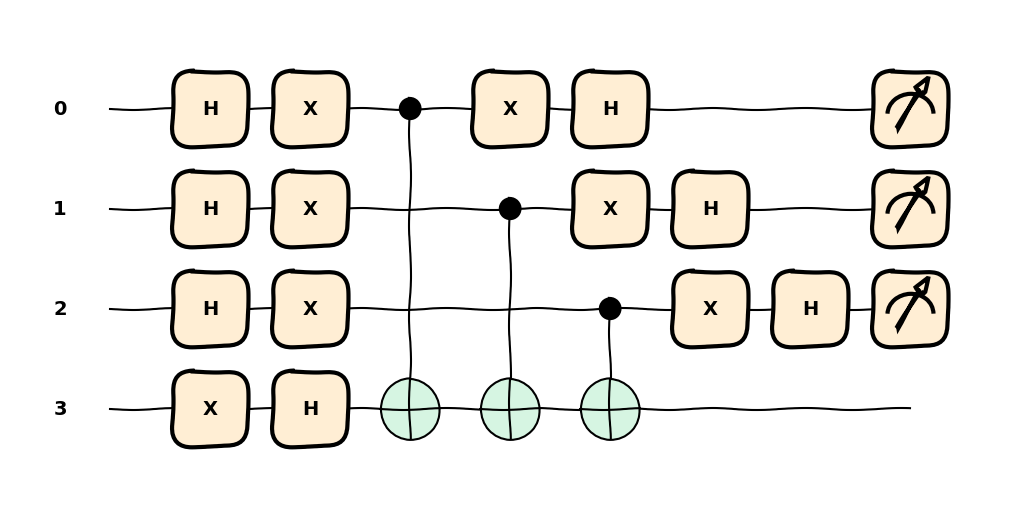

In [20]:
qml.draw_mpl(circuit_b, expansion_strategy='device')()
plt.show()

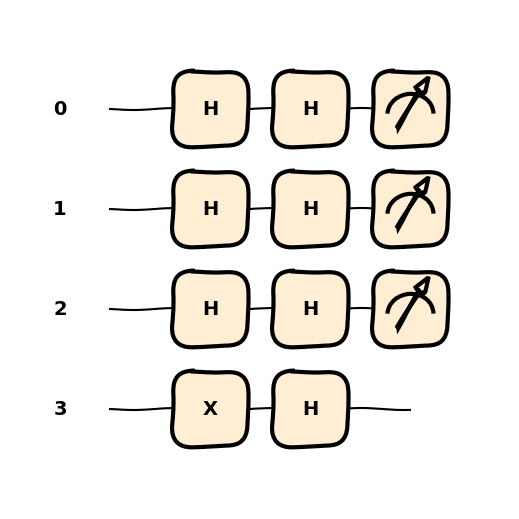

In [21]:
qml.draw_mpl(circuit_c, expansion_strategy='device')()
plt.show()

In [22]:
def query_complexity_quantum_constant(n):
    times = []
    for i in range(1, n+1):
        dev, circuit = gen_deutsch_jozsa('constant', i)
        start = timeit.default_timer()
        dj = circuit()
        is_equal(dj[0], 1.0)
        stop = timeit.default_timer()
        times.append(stop - start)
    return times

In [23]:
quantum_times = query_complexity_quantum_constant(10)

In [24]:
classical_times = np.array(classical_times)
quantum_times = np.array(quantum_times)

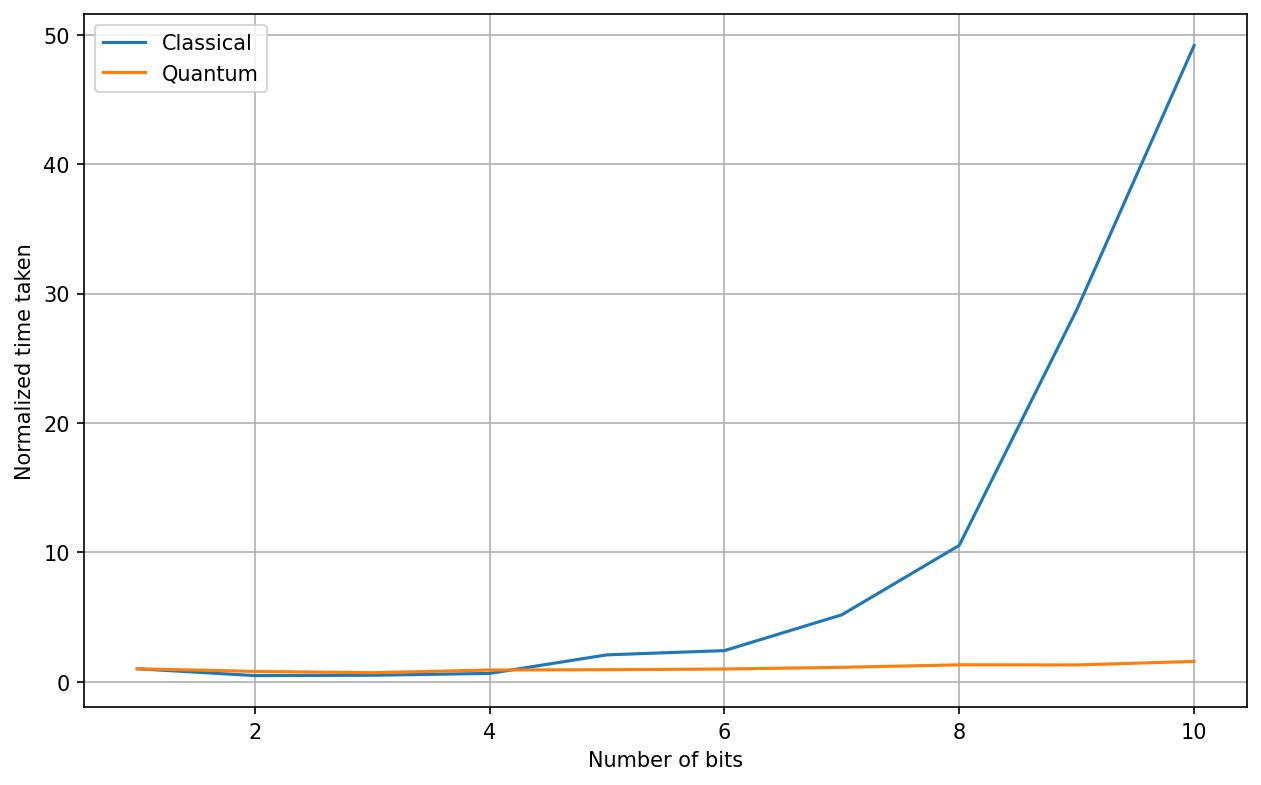

In [25]:
plt.figure(figsize=(10, 6), dpi=150)
plt.plot(range(1, 11), classical_times / classical_times[0], label='Classical')
plt.plot(range(1, 11), quantum_times / quantum_times[0], label='Quantum')
plt.xlabel('Number of bits')
plt.ylabel('Normalized time taken')
plt.legend()
plt.grid()
plt.show()

### Run with IBM Quantum Experience

In [26]:
# def gen_deutsch_jozsa(case:str,n:int):
#     dev = qml.device('qiskit.ibmq', wires=n+1, backend='ibmq_qasm_simulator', shots=1024)
#     @qml.qnode(dev)
#     def circuit():
#         # Apply X gate to the last qubit to make the state |1>
#         qml.PauliX(wires=n)

#         # Add barrier to separate input state from rest of circuit
#         qml.Barrier(wires=range(n+1))

#         # Apply Hadamard gates to all qubits
#         for i in range(n+1):
#             qml.Hadamard(wires=i)

#         # Apply U_f
#         Oracle(case, n, wires=range(n+1))

#         # Apply Hadamard gates to all qubits
#         for i in range(n):
#             qml.Hadamard(wires=i)
        
#         # Measure all qubits
#         return qml.probs(wires=range(n))
#     return dev, circuit

In [27]:
# def query_complexity_quantum_constant(n):
#     times = []
#     for i in range(1, n+1):
#         dev, circuit = gen_deutsch_jozsa('constant', i)
#         start = timeit.default_timer()
#         dj = circuit()
#         is_equal(dj[0], 1.0, 1e-1)
#         stop = timeit.default_timer()
#         times.append(stop - start)
#     return times

In [28]:
# quantum_times = query_complexity_quantum_constant(10)

In [29]:
# quantum_times = [
#     0.005485967,
#     0.002162124,
#     0.004567849,
#     0.003109943,
#     0.003303143,
#     0.092140306,
#     0.010469479,
#     0.002274819,
#     0.003467794
# ]

In [30]:
# plt.figure(figsize=(10, 6), dpi=150)
# plt.plot(range(1, 10), quantum_times, label='Quantum')
# plt.xlabel('Number of bits')
# plt.ylabel('Time taken (s)')
# plt.legend()
# plt.grid()
# plt.show()